In [130]:
import pandas as pd # 0.21.0
import numpy as np
from time import time

import scipy
from scipy import stats
import matplotlib.pyplot as plt

import quandl

In [131]:
np.random.seed(100)
quandl.ApiConfig.api_key = "2iPu61nT4WXex2sh1zsS"

In [132]:
def get_returns(ticker, start, end):
    try:
        df = quandl.get("WIKI/"+ticker, start_date=start, end_date=end)
    except Exception as e:
        print("Error in getting stock data: {}".format(e))

    df = pd.DataFrame(df['Adj. Close'] )
    df = pre_process(df)
    del df['Adj. Close']
    return df

def pre_process(df):
    df["log_returns"] =  np.log(df/df.shift(1))
    df_index = df.index[0:-1]
    df = df[1:]
    df.index = df_index
    return df

In [133]:
df = get_returns("AAPL", "10-01-14", "10-10-17")

In [134]:
df.head()

,log_returns
Date,
2010-01-14,-0.016853
2010-01-15,0.043288
2010-01-19,-0.015536
2010-01-20,-0.017404
2010-01-21,-0.050881


### Create lagged features

In [159]:

steps = 20
lags_df = (pd.concat(
    [df.log_returns.shift(i) for i in range(steps)],
    axis=1,
    keys=['log_returns'] + ['log_returns_L%s' % i for i in range(1, steps)]
).dropna()
)
# To ensure that only past frames are used to predict current steering.
# (e.g to predict target at t, we use t-1,t-2, etc.)
lags_df = lags_df.drop(['log_returns'], axis=1)
final_df = pd.merge(df, lags_df, left_index=True, right_index=True)

In [160]:
final_df.head()

,log_returns,log_returns_L1,log_returns_L2,log_returns_L3,log_returns_L4,log_returns_L5,log_returns_L6,log_returns_L7,log_returns_L8,log_returns_L9,log_returns_L10,log_returns_L11,log_returns_L12,log_returns_L13,log_returns_L14,log_returns_L15,log_returns_L16,log_returns_L17,log_returns_L18,log_returns_L19
Date,,,,,,,,,,,,,,,,,,,,
2010-02-11,0.008570,0.018051,-0.005489,0.010607,-0.006879,0.017600,-0.036704,0.017060,0.005786,0.013791,-0.036938,-0.042219,0.009395,0.014009,0.026572,-0.050881,-0.017404,-0.015536,0.043288,-0.016853
2010-02-12,0.014959,0.008570,0.018051,-0.005489,0.010607,-0.006879,0.017600,-0.036704,0.017060,0.005786,0.013791,-0.036938,-0.042219,0.009395,0.014009,0.026572,-0.050881,-0.017404,-0.015536,0.043288
2010-02-16,-0.004188,0.014959,0.008570,0.018051,-0.005489,0.010607,-0.006879,0.017600,-0.036704,0.017060,0.005786,0.013791,-0.036938,-0.042219,0.009395,0.014009,0.026572,-0.050881,-0.017404,-0.015536
2010-02-17,0.001864,-0.004188,0.014959,0.008570,0.018051,-0.005489,0.010607,-0.006879,0.017600,-0.036704,0.017060,0.005786,0.013791,-0.036938,-0.042219,0.009395,0.014009,0.026572,-0.050881,-0.017404
2010-02-18,-0.006219,0.001864,-0.004188,0.014959,0.008570,0.018051,-0.005489,0.010607,-0.006879,0.017600,-0.036704,0.017060,0.005786,0.013791,-0.036938,-0.042219,0.009395,0.014009,0.026572,-0.050881


In [161]:
# convert return into binary to format for classification
final_df["y"] = final_df.apply(lambda x: 1 if x['log_returns'] > 0 else 0 , axis=1)
del final_df["log_returns"]

In [162]:
y = final_df.pop("y")
X = final_df

In [163]:
print("y shape: {}".format(y.shape))
print("X shape: {}".format(X.shape))

y shape: (171,)
X shape: (171, 19)


### Assess distribution and statistics of data

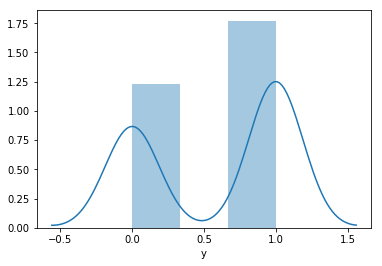

In [164]:

import seaborn as sns
%matplotlib inline
sns.distplot(y)

In [165]:
y.describe()

count    171.000000
mean       0.590643
std        0.493159
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: y, dtype: float64

In [149]:
train_size = int(X.shape[0]*0.9)

### Split into train and test

In [150]:
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print("y Train shape: {}".format(y_train.shape))
print("X Train shape: {}".format(X_train.shape))
print("y Test shape: {}".format(y_test.shape))
print("X Test shape: {}".format(X_test.shape))

y Train shape: (153,)
X Train shape: (153, 19)
y Test shape: (18,)
X Test shape: (18, 19)


### Train RandomForest classifier

In [171]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

rfc = RandomForestClassifier()
rfc_model = rfc.fit(X_train, y_train)
pred = rfc_model.predict(X_test)
print("Accuracy for Random Forest Model: %.2f" % (accuracy_score(y_test, pred) * 100))
print("RMSE for Random Forest Model: %.2f" % (rmse(y_test, pred) * 100))


Accuracy for Random Forest Model: 61.11
RMSE for Random Forest Model: 62.36
